# Final Model Alex + YOLO + Seperate Classification

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn import svm
from sklearn.externals import joblib
from keras.models import Model

Using TensorFlow backend.


In [2]:
# The final version of our model
model = Sequential()

model.add(ZeroPadding2D((2, 2), input_shape=(256, 256, 3)))
model.add(Convolution2D(64, (11, 11), strides=(4, 4), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

model.add(ZeroPadding2D((2, 2)))
model.add(Convolution2D(192, (5, 5), activation='relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(384, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(MaxPooling2D((3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu',kernel_regularizer=regularizers.l1(0.)))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu',kernel_regularizer=regularizers.l1(0.)))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 260, 260, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        23296     
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 192)       307392    
________________________________________________

In [3]:
# Load weights
model.load_weights('CNN_40_64 0.9.h5')

In [4]:
# import test data and labels
X_test = np.load('test_rgb_final.npy')  
true_label= np.load('test_label_final.npy')
pre_label = model.predict(X_test) 

In [5]:
# here are two groups of garbage that can make confusion
confused_type1 = [2,10]
confused_type2 = [9,11,13]

#testing data
X_bl = [] #contains bread and leftovers
y_bl = []
X_gmp = [] #contains glass, mental and plastic
y_gmp = []
index_bl = []
index_gmp = []
pre_y = []
for i in range(len(X_test)):
    label = np.argmax(pre_label[i])
    pre_y.append(label)
    if (label in confused_type1) == True: #if the label is bread or leftovers
        X_bl.append(X_test[i])
        y_bl.append(pre_label[i])
        index_bl.append(i)
    if (label in confused_type2) == True: #if the label is glass or mental or plastic
        X_gmp.append(X_test[i])
        y_gmp.append(pre_label[i])
        index_gmp.append(i)

In [6]:
X_bl = np.array(X_bl)
y_bl = np.array(y_bl)
X_gmp = np.array(X_gmp)
y_gmp = np.array(y_gmp)
pre_y = np.array(pre_y)

In [7]:
# Use our trained CNN model to do data extraction
model1 = Sequential()

model1.add(ZeroPadding2D((2, 2), input_shape=(256, 256, 3)))
model1.add(Convolution2D(64, (11, 11), strides=(4, 4), activation='elu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((3, 3), strides=(2, 2)))

model1.add(ZeroPadding2D((2, 2)))
model1.add(Convolution2D(192, (5, 5), activation='relu'))
model1.add(MaxPooling2D((3, 3), strides=(2, 2)))

model1.add(ZeroPadding2D((1, 1)))
model1.add(Convolution2D(384, (3, 3), activation='relu'))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Convolution2D(256, (3, 3), activation='relu'))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Convolution2D(256, (3, 3), activation='relu'))
model1.add(ZeroPadding2D((1, 1)))
model1.add(Convolution2D(128, (3, 3), activation='relu'))
model1.add(ZeroPadding2D((1, 1)))
model1.add(MaxPooling2D((3, 3), strides=(2, 2)))

model1.add(Flatten())
model1.add(Dense(4096, activation='relu',kernel_regularizer=regularizers.l1(0.)))
model1.add(Dropout(0.5))
model1.add(Dense(4096, activation='relu',kernel_regularizer=regularizers.l1(0.)))
model1.add(Dropout(0.5))
model1.add(Dense(14, activation='softmax'))
model1.load_weights('CNN_40_64 0.8721.h5')

In [8]:
get_feature=Model(inputs=model1.input,outputs=model1.layers[20].output)
feature=get_feature.predict(X_bl)
model_bl = joblib.load('train1_model.m')
bl_label=model_bl.predict(feature)

In [9]:
# The CNN model to classify glass, mental and plastic
model_gmp = Sequential()
model_gmp.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(256, 256, 3)))
model_gmp.add(Activation('elu'))
model_gmp.add(Conv2D(32, (3, 3)))
model_gmp.add(Activation('relu'))
model_gmp.add(MaxPooling2D(pool_size=(2, 2)))

model_gmp.add(Conv2D(64, (3, 3), padding='same'))
model_gmp.add(Activation('relu'))
model_gmp.add(Conv2D(64, (3, 3)))
model_gmp.add(Activation('relu'))
model_gmp.add(MaxPooling2D(pool_size=(2, 2)))

model_gmp.add(Conv2D(128, (3, 3), padding='same'))
model_gmp.add(Activation('relu'))
model_gmp.add(Conv2D(128, (3, 3)))
model_gmp.add(Activation('relu'))
model_gmp.add(MaxPooling2D(pool_size=(2, 2)))

model_gmp.add(Conv2D(256, (3, 3), padding='same'))
model_gmp.add(Activation('relu'))
model_gmp.add(Conv2D(256, (3, 3)))
model_gmp.add(Activation('relu'))
model_gmp.add(Conv2D(128, (1, 1)))
model_gmp.add(MaxPooling2D(pool_size=(2, 2)))

model_gmp.add(Flatten())
model_gmp.add(Dense(512))
model_gmp.add(Activation('relu'))
model_gmp.add(Dropout(0.5))
model_gmp.add(Dense(128))
model_gmp.add(Activation('relu'))
model_gmp.add(Dropout(0.5))
model_gmp.add(Dense(3))
model_gmp.add(Activation('softmax'))

In [10]:
model_gmp.load_weights('CNN-class 9,11,13 0.7652.h5')
pred_gmp = model_gmp.predict(X_gmp)

In [11]:
# 
gmp_label = []
for i in range(len(pred_gmp)):
    label = np.argmax(pred_gmp[i])
    if label == 0:
        gmp_label.append(9)
    if label == 1:
        gmp_label.append(11)
    if label == 2:
        gmp_label.append(13)

In [12]:
# insert the ... into the ...
pre_y[index_gmp] = gmp_label
pre_y[index_bl] = bl_label

In [13]:
maps={'bandaid': 0,
 'battery': 1,
 'bread': 2,
 'bulb': 3,
 'cardboard': 4,
 'chopsticks': 5,
 'cigarettebutt': 6,
 'diapers': 7,
 'facialmask': 8,
 'glass': 9,
 'leftovers': 10,
 'metal': 11,
 'paper': 12,
 'plastic': 13}
inv_maps={v:k for k,v in maps.items()}


In [14]:
count = 0
test = []
for i in true_label:
    test.append(maps[i])
for i in range(len(pre_y)):
    a = pre_y[i]
    true = test[i]
    if a == true:
        count += 1
acc = count/len(pre_y)
print('accuracy for small categories: '+str(acc))

accuracy for small categories: 0.85


In [15]:
dic = {1:0,3:0,2:1,10:1,4:2,9:2,11:2,12:2,13:2,0:3,5:3,6:3,7:3,8:3}
count = 0
for i in range(len(pre_y)):
    y_true = test[i]
    test_class = dic[y_true]
    a = pre_y[i]
    pre_class = dic[a]
    if pre_class == test_class:
        count += 1
acc = count/len(pre_y)
print('accuracy for big categories: '+str(acc))

accuracy for big categories: 0.95


In [16]:
from PIL import Image
import matplotlib.pyplot as plt

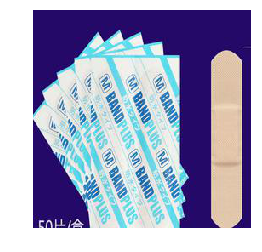

The predict small category is bandaid. The true small category is bandaid.
True!
the predict big category is residual. The true big category is residual.
True!





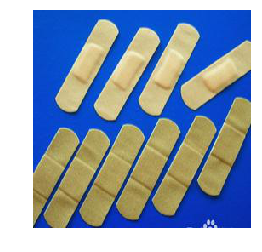

The predict small category is bandaid. The true small category is bandaid.
True!
the predict big category is residual. The true big category is residual.
True!





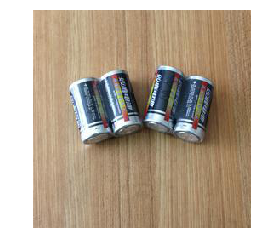

The predict small category is battery. The true small category is battery.
True!
the predict big category is harmful. The true big category is harmful.
True!





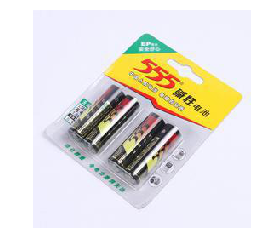

The predict small category is battery. The true small category is battery.
True!
the predict big category is harmful. The true big category is harmful.
True!





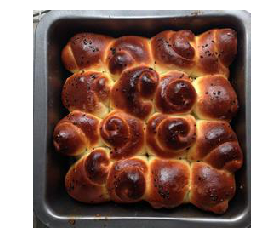

The predict small category is bread. The true small category is bread.
True!
the predict big category is organic. The true big category is organic.
True!





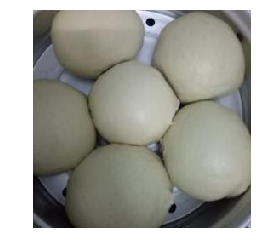

The predict small category is diapers. The true small category is bread.
False!
the predict big category is residual. The true big category is organic.
False!





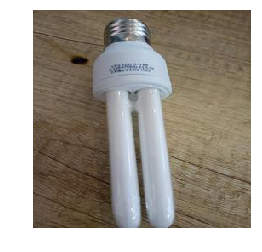

The predict small category is bulb. The true small category is bulb.
True!
the predict big category is harmful. The true big category is harmful.
True!





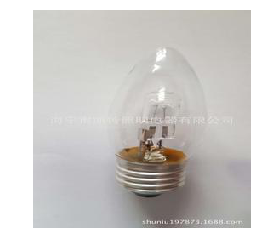

The predict small category is bulb. The true small category is bulb.
True!
the predict big category is harmful. The true big category is harmful.
True!





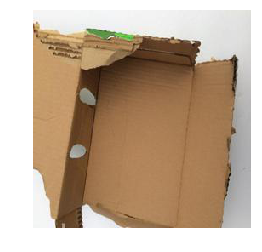

The predict small category is cardboard. The true small category is cardboard.
True!
the predict big category is recoverable. The true big category is recoverable.
True!





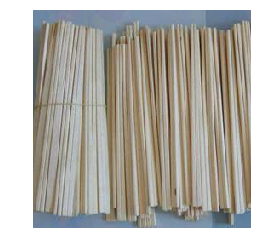

The predict small category is chopsticks. The true small category is chopsticks.
True!
the predict big category is residual. The true big category is residual.
True!





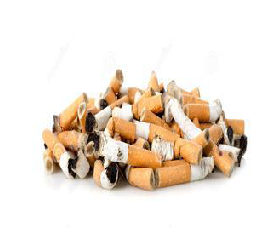

The predict small category is cigarettebutt. The true small category is cigarettebutt.
True!
the predict big category is residual. The true big category is residual.
True!





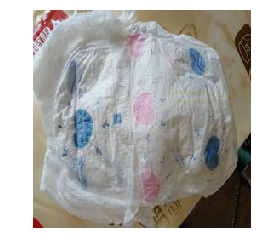

The predict small category is diapers. The true small category is diapers.
True!
the predict big category is residual. The true big category is residual.
True!





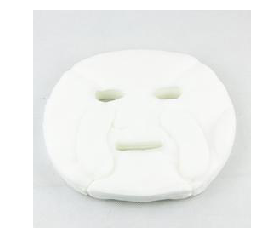

The predict small category is facialmask. The true small category is facialmask.
True!
the predict big category is residual. The true big category is residual.
True!





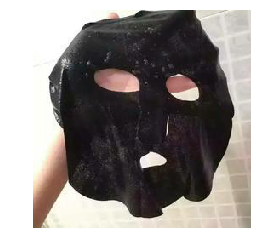

The predict small category is facialmask. The true small category is facialmask.
True!
the predict big category is residual. The true big category is residual.
True!





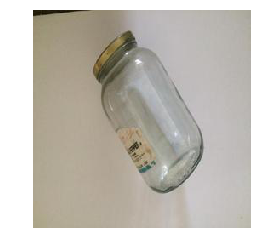

The predict small category is glass. The true small category is glass.
True!
the predict big category is recoverable. The true big category is recoverable.
True!





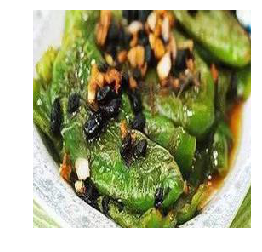

The predict small category is leftovers. The true small category is leftovers.
True!
the predict big category is organic. The true big category is organic.
True!





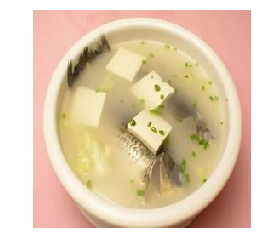

The predict small category is leftovers. The true small category is leftovers.
True!
the predict big category is organic. The true big category is organic.
True!





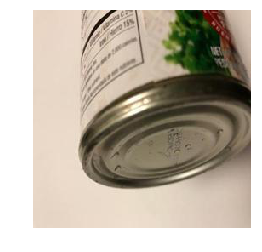

The predict small category is glass. The true small category is metal.
False!
the predict big category is recoverable. The true big category is recoverable.
True!





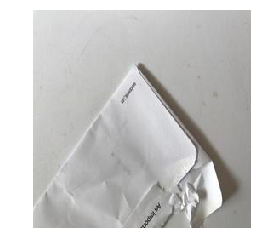

The predict small category is paper. The true small category is paper.
True!
the predict big category is recoverable. The true big category is recoverable.
True!





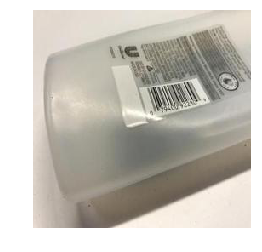

The predict small category is metal. The true small category is plastic.
False!
the predict big category is recoverable. The true big category is recoverable.
True!





In [17]:
big={0:'harmful',1:'organic',2:'recoverable',3:'residual'}
for i in range(len(pre_y)):
    plt.imshow(Image.fromarray(X_test[i]))
    plt.axis('off')
    plt.show()
    print("The predict small category is "+inv_maps[pre_y[i]]+'. The true small category is '+inv_maps[test[i]]+'.')
    if inv_maps[pre_y[i]]==inv_maps[test[i]]:
        print('True!')
    else:
        print('False!')
    print("the predict big category is "+big[dic[pre_y[i]]]+'. The true big category is '+big[dic[test[i]]]+'.')
    if big[dic[pre_y[i]]]==big[dic[test[i]]]:
        print('True!\n\n')
    else:
        print('False!\n\n')
    print()